In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from PIL import Image
import tifffile
import os

from data_loader import image_loader
from data_loader import image_augmentation as aug
from models import cnn_2d, double_decoder_cnn

from tqdm.notebook import tqdm
import importlib
import json
from datetime import datetime

2022-05-06 10:46:31.249314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import tensorflow as tf
import tensorflow.keras.layers as lay
import tensorflow.keras.optimizers as opt
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import model_from_json
# import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.4.0


In [3]:
import tensorboard
tensorboard.__version__

'2.8.0'

In [4]:
print("number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

number of GPUs available:  1


2022-05-06 10:46:38.867298: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-06 10:46:38.882895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-06 10:46:38.989659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-06 10:46:38.989747: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-06 10:46:39.083858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-06 10:46:39.084003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4281024579884929492
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23512768896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10155469296253205812
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6"
]


2022-05-06 10:46:42.224176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 10:46:42.228113: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-06 10:46:42.230458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-06 10:46:42.230568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-06 10:46:42.230629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Su

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
working_dir = "/group/ag_cmb/mohsen_simtemp/data/xray_tomography/"

#result_dir = "../results/series_19/semi_supervised/"
#name_str = "semisupervised_march_2021_1"

#result_dir = "../results/series_21/semi_supervised/"
result_dir = "../results/series_22/semi_supervised/"

#name_str = "semisupervised_april_2021_1"
name_str = "semisupervised_may_2021_1"
#name_str = "semisupervised_august_2021_1"

save_figures = False

#trn_dim = 64
#trn_dim = 128
trn_dim = 256
trn_dim_small = 96

test_split_fraction = 0.1

#batch_size = 16
batch_size = 1

# Data preparation

In [8]:
dataset_folder_small = [working_dir + "raw_training_sets/small_clips/current_dataset"]
dataset_folder_img_lbl = [working_dir + "raw_training_sets/single_frame/current_dataset"]
dataset_folder_img_img = [working_dir + "raw_training_sets/single_frame/semi_supervised"]

In [9]:
# data_generator_small = trg.ImageLoader(dataset_folders=[],#dataset_folder_small,
#                                  test_split_fraction=test_split_fraction,
#                                  use_labels=True,
#                                  image_normalizing_function=lambda x : x,
#                                  label_normalizing_function=normalize_image,
#                                  do_enhance=True, image_enhance_function=enhance_image)

data_generator_img_img = image_loader.ImageLoader(dataset_folders=None, #dataset_folder_img_img,
                                 test_split_fraction=test_split_fraction,
                                 use_labels=False,
                                 image_processing_function=image_loader.image_preprocessing_function,
                                 label_processing_function=None)

In [10]:
data_generator_img_lbl = image_loader.ImageLoader(dataset_folders=None, #dataset_folder_img_lbl,
                                 test_split_fraction=test_split_fraction,
                                 use_labels=True,
                                 image_processing_function=image_loader.image_preprocessing_function,
                                 label_processing_function=image_loader.label_preprocessing_function)

In [11]:
# data_generator_small.save_to_file(working_dir + "/processed_training_sets/dataset_small_" + name_str)
# data_generator_img_img.save_to_file(working_dir + "/processed_training_sets/dataset_images_" + name_str)
# data_generator_img_lbl.save_to_file(working_dir + "/processed_training_sets/dataset_image_labels_" + name_str)

In [12]:
# data_generator_small.load_from_file(working_dir + "/processed_training_sets/dataset_small_" + name_str)
data_generator_img_img.load_from_file(working_dir + "/processed_training_sets/dataset_images_" + name_str)
data_generator_img_lbl.load_from_file(working_dir + "/processed_training_sets/dataset_image_labels_" + name_str)

Loading zipped datasets from file...done!
Max. image dimensions = 1324
Loading zipped datasets from file...done!
Max. image dimensions = 1324


In [13]:
# print(f"max. dataset size (small) = {len(data_generator_small.trn_img_list)}")
print(f"max. dataset size (image-image) = {len(data_generator_img_img.trn_img_list)}")
print(f"max. dataset size (image-label) = {len(data_generator_img_lbl.trn_img_list)}")

max. dataset size (image-image) = 461
max. dataset size (image-label) = 71


In [14]:
img_value_range = np.amax(data_generator_img_img.trn_img_list) - np.amin(data_generator_img_img.trn_img_list)

print(img_value_range)

7.6105123


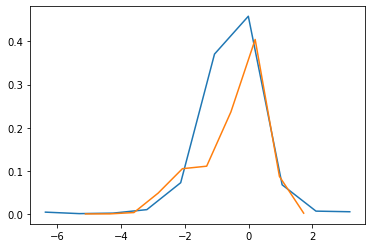

In [15]:
mean_img_img = np.mean(data_generator_img_img.trn_img_list)
std_img_img = np.std(data_generator_img_img.trn_img_list)

mean_img_lbl = np.mean(data_generator_img_lbl.trn_img_list)
std_img_lbl = np.std(data_generator_img_lbl.trn_img_list)


hist, bin_edges = np.histogram(data_generator_img_lbl.test_img_list)
hist = hist / np.sum(hist)
plt.plot(bin_edges[:-1], hist)

hist, bin_edges = np.histogram(data_generator_img_img.test_img_list)
hist = hist / np.sum(hist)

plt.plot(bin_edges[:-1], hist)

In [16]:
print(mean_img_img, std_img_img)
print(mean_img_lbl, std_img_lbl)

0.0071360315 0.99432784
-3.8498732e-05 0.9872348


In [17]:
# trn_input_small, test_input_small = data_generator_small.get_dataset()
trn_input_img_img, test_input_img_img = data_generator_img_img.get_dataset()
trn_input_img_lbl, test_input_img_lbl = data_generator_img_lbl.get_dataset()

Compiling tensorflow datasets...

2022-05-06 10:56:25.304172: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-06 10:56:25.306665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-06 10:56:25.306794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-06 10:56:25.306862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-06 10:56:25.306893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-05-06 10:56:25.306922: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
20

done!
Compiling tensorflow datasets...done!


In [18]:
# augmentation_func_small = aug.augmentation_function(data_generator_small.max_dim, trn_dim_small,
#                                               random_rotation=True,
#                                               random_reflection=True,
#                                               random_contrast=False)

# training_dataset_small = trn_input_small.\
#                     repeat(pipeline_size).\
#                     map(map_func=augmentation_func_small).\
#                     batch(batch_size)

# test_dataset_small = test_input_small.\
#                     repeat(pipeline_size).\
#                     map(map_func=augmentation_func_small).\
#                     batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)


augmentation_func_img_img = aug.augmentation_function(data_generator_img_img.max_dim, trn_dim,
                                              random_rotation=True,
                                              random_reflection=True,
                                              random_contrast=False)

training_dataset_img_img = trn_input_img_img.\
                    repeat(batch_size).\
                    map(map_func=augmentation_func_img_img).\
                    shuffle(len(trn_input_img_img) * batch_size, reshuffle_each_iteration=True).\
                    batch(batch_size)


test_dataset_img_img = test_input_img_img.\
                    repeat(batch_size).\
                    map(map_func=augmentation_func_img_img).\
                    batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)


augmentation_func_img_lbl = aug.augmentation_function(data_generator_img_lbl.max_dim, trn_dim,
                                              random_rotation=True,
                                              random_reflection=True,
                                              random_contrast=False)

training_dataset_img_lbl = trn_input_img_lbl.\
                    repeat(batch_size * 6).\
                    map(map_func=augmentation_func_img_lbl).\
                    shuffle(len(trn_input_img_lbl) * batch_size * 6, reshuffle_each_iteration=True).\
                    batch(batch_size)


test_dataset_img_lbl = test_input_img_lbl.\
                    repeat(batch_size * 6).\
                    map(map_func=augmentation_func_img_lbl).\
                    batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)

print(training_dataset_img_img.cardinality)
print(training_dataset_img_lbl.cardinality)

<bound method DatasetV2.cardinality of <BatchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>>
<bound method DatasetV2.cardinality of <BatchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>>


2022-05-06 10:56:30.247251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-06 10:56:30.283303: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


-5.1182857 2.4922266 -5.1182857 2.4922266
-4.390157 -0.24772018 -4.390157 -0.24772018
-5.1182857 2.4922266 -5.1182857 2.4922266
0.43999553 1.3852854 0.43999553 1.3852854
-5.0805435 -0.3244816 -5.0805435 -0.3244816
0.59955657 1.0061243 0.59955657 1.0061243
-0.96748745 1.3848209 -0.96748745 1.3848209
-0.74672645 0.73763406 -0.74672645 0.73763406
-2.893951 0.09985397 -2.893951 0.09985397
-4.3430085 2.3342915 -4.3430085 2.3342915
-3.640236 2.1383731 -1.0 1.0
-3.2823422 2.5236356 -1.0 1.0
-1.9170014 1.8067139 -1.0 1.0
-3.8068752 2.7129467 -1.0 1.0
-6.373509 4.239421 -1.0 1.0
-4.1668744 2.348899 -1.0 1.0
-1.6535202 2.3474414 -1.0 -1.0
-6.373509 4.239421 -1.0 1.0
-3.4000747 1.9089003 -1.0 1.0
-2.4256642 2.0692239 -1.0 1.0


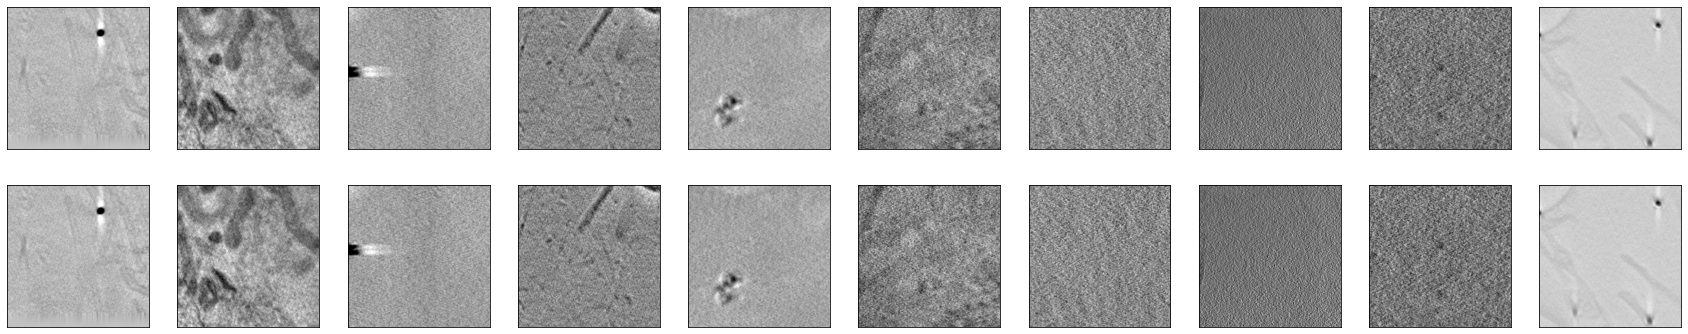

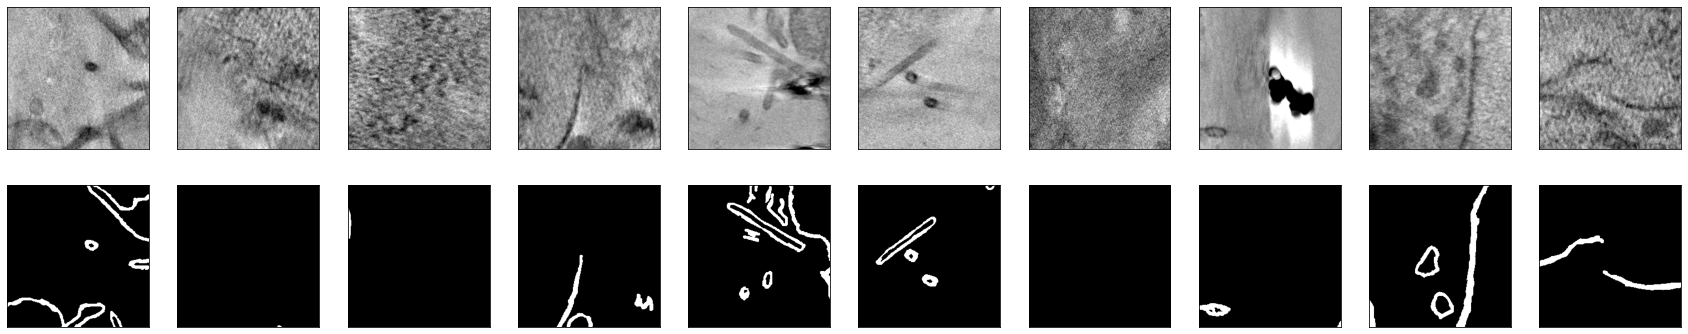

In [19]:
def show_samples(fig, _iter, n_images):
    
    for i in range(n_images):
        img_list, lbl_list = next(_iter)
        img, lbl = img_list[0], lbl_list[0]
        print(np.amin(img), np.amax(img), np.amin(lbl), np.amax(lbl))
        ax = [fig.add_subplot(2, n_images, i + 1), fig.add_subplot(2, n_images, i + n_images + 1)]
        ax[0].imshow (img[:, :, 0], cmap='gray')
        ax[1].imshow (lbl[:, :, 0], cmap='gray')
        
        for _ax in ax:
            _ax.tick_params(axis='both', which='both',
                            bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labelleft=False)
        
n_images = 10
_fig_size = (3.0 * n_images, 3.0 * 2)

# fig = plt.figure (figsize=_fig_size)
# show_samples(fig, training_dataset_small.as_numpy_iterator(), n_images)

fig = plt.figure (figsize=_fig_size)
show_samples(fig, test_dataset_img_img.as_numpy_iterator(), n_images)

fig = plt.figure (figsize=_fig_size)
show_samples(fig, test_dataset_img_lbl.as_numpy_iterator(), n_images)

# Network definition

In [20]:
m_f = 64

encoder_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                  'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                  'add_instead_of_concat':False,
                  'n_filters': [m_f, m_f, 2 * m_f, 4 * m_f, 8 * m_f],
                  'activation': {'type': 'relu'},
                  'dropout': {'active': False},
                  'batch_norm': {'active': True}}

neck_config = {'kernel_sizes': [1, 2, 3],
               'depth': 4, 'n_filters': 16 * m_f,
               'activation': {'type': 'relu'},
               'dropout': {'active': False},
               'batch_norm': {'active': True}}

decoder_image_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                        'n_stages': 4, 'n_blocks': 1, 'block_depth': 2,
                        'add_instead_of_concat':False,
                        'use_skip_connections': False,
                        'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                        'activation': {'type': 'relu'},
                        'dropout': {'active': False},
                        'batch_norm': {'active': True}}

decoder_label_config = {'kernel_sizes': [3, 3, 3, 3, 3],
                        'n_stages': 4, 'n_blocks': 2, 'block_depth': 2,
                        'add_instead_of_concat':False,
                        'use_skip_connections': True,
                        'n_filters': [8 * m_f, 4 * m_f, 2 * m_f, m_f, m_f],
                        'activation': {'type': 'relu'},
                        'dropout': {'active': False},
                        'batch_norm': {'active': True}}


model_config = {'pooling': None, 'm_f': m_f, 'add_instead_of_concat_after_neck': False,
                              'encoder': encoder_config,
                              'neck': neck_config,
                              'decoder_image': decoder_image_config,
                              'decoder_label': decoder_label_config}


with open(working_dir + 'saved_cnn_model/model_config_' + name_str + '.json', 'w') as f_conf:
    json.dump(model_config, f_conf, indent=4)

In [21]:
dd_model = double_decoder_cnn.MyDoubleDecoderNet(config=model_config)

#tmp_input = tf.zeros((1, trn_dim, trn_dim, 1))
#tmp_output = dd_model(tmp_input, training=False)

dd_model.build(input_shape=(None, trn_dim, trn_dim, 1))

dd_model.summary ()

skip connections in image decoder: False
skip connections in label decoder: True
Model: "my_double_decoder_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (MyEncoderBlock)     multiple                  2286240   
_________________________________________________________________
mid_branch_0 (MyMidBranchBlo multiple                  5259264   
_________________________________________________________________
mid_branch_1 (MyMidBranchBlo multiple                  8404992   
_________________________________________________________________
mid_branch_2 (MyMidBranchBlo multiple                  13647872  
_________________________________________________________________
image_decoder (MyDecoderBloc multiple                  19543488  
_________________________________________________________________
image_decoder_final_convolut multiple                  13440     
______________________________

## Saving/loading network weights

In [22]:
save_model = False
load_model = True

In [23]:
if load_model:
    dd_model.load_weights(working_dir + 'saved_cnn_model/weights_' + name_str + '.h5')

## Tensorboard

In [25]:
# logdir="./logs/graph/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# @tf.function
# def traceme(x):
#     return dd_model(x)


# writer = tf.summary.create_file_writer(logdir)

# tf.summary.trace_on(graph=True, profiler=True)

# tmp_output = traceme(tf.zeros((1, trn_dim, trn_dim, 1)))

# with writer.as_default():
#     tf.summary.trace_export(
#       name="double_decoder_net",
#       step=0,
#       profiler_outdir=logdir)

## Training

In [65]:
#tensorboard_callback.set_model(dd_model)
#tensorboard_callback.set_params(dd_model.trainable_variables)

tmp_input = tf.ones((1, trn_dim, trn_dim, 1))
tmp_output = dd_model(tmp_input, training=True)

In [66]:
#print(tmp_output)
print(tf.math.reduce_std(tmp_output[0]))
print(tf.math.reduce_std(tmp_output[1]))

tf.Tensor(0.04792829, shape=(), dtype=float32)
tf.Tensor(0.154679, shape=(), dtype=float32)


In [109]:
def JS_divergence(p, q):
    # is this Jensen-Shannon divergence (JSD)?
    return 0.5 * tf.keras.losses.KLDivergence()(q, p) +\
            0.5 * tf.keras.losses.KLDivergence()(p, q)

def image_reconstruction_loss(input_img, y_true, y_pred):
    
    alpha = 0.5
    
    return alpha * (tf.math.reduce_sum(1.0 - tf.image.ssim(input_img, y_pred[0],
                                                           img_value_range, filter_size=11, filter_sigma=1.5,
                                                           k1=0.01, k2=0.03), axis=0)) +\
            (1.0 - alpha) * tf.keras.losses.Huber(delta=0.1)(input_img, y_pred[0]) +\
            tf.keras.losses.MeanSquaredError()(y_pred[1], y_pred[1])

def label_loss(input_img, y_true, y_pred):
    
    alpha = 0.99
    
    return (1.0 - alpha) * tf.keras.losses.Huber(delta=0.1)(input_img, y_pred[0]) +\
           alpha * tf.keras.losses.Huber(delta=0.1)(y_true, y_pred[1])  

def label_accuracy_function(label, prediction):

    prediction = tf.clip_by_value(0.5 * (prediction[1] + tf.ones_like(prediction[1])), 0.0, 1.0)
    label = tf.clip_by_value(0.5 * (label + tf.ones_like(label)), 0.0, 1.0)
    
    num_of_pixels = tf.reduce_sum(tf.ones_like(label))
    num_of_correct_pixels = tf.reduce_sum(
        tf.cast(tf.math.less_equal(tf.abs(label - prediction), 0.01 * tf.ones_like(label)), dtype=tf.float32))
                                                         
    #pred_score = 1.0 - tf.norm(label - prediction, 1) / (1.0e-6 + tf.norm(label, 1))
    pred_score = num_of_correct_pixels / num_of_pixels
    
    return tf.clip_by_value(pred_score, 0.0, 1.0)

def image_accuracy_function(label, prediction):

    #prediction = tf.clip_by_value(0.5 * (prediction[0] + tf.ones_like(prediction[1])), 0.0, 1.0)
    #label = tf.clip_by_value(0.5 * (label + tf.ones_like(label)), 0.0, 1.0)

    num_of_pixels = tf.reduce_sum(tf.ones_like(label))
    num_of_correct_pixels = tf.reduce_sum(
        tf.cast(tf.math.less_equal(tf.abs(label - prediction[0]), tf.ones_like(label) * tf.math.reduce_std(label)), dtype=tf.float32))

    #pred_score = 1.0 - tf.norm(label - prediction, 1) / tf.norm(label, 1)
    pred_score = num_of_correct_pixels / num_of_pixels

    return tf.clip_by_value(pred_score, 0.0, 1.0)

In [110]:
class MyDoubleTrainer:
    def __init__(self, model, training_dataset, test_dataset,
                 optimizer=None, loss_function=None, accuracy_function=None):

        self.model = model
        self.training_dataset = training_dataset
        self.test_dataset = test_dataset

        if optimizer is None:
#             optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

        self.optimizer = optimizer
        self.loss_function = loss_function
        self.accuracy_function = accuracy_function

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

        self.epoch = None
        self.train_loss_list, self.test_loss_list = None, None
        self.train_accuracy_list, self.test_accuracy_list = None, None

        self.reset_training_loop()

    @tf.function
    def __train_step(self, images, labels):

        with tf.GradientTape() as tape:
            predictions = self.model(images, training=True)
            loss = self.loss_function(images, labels, predictions)
            accuracy = self.accuracy_function(labels, predictions)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(accuracy)

    @tf.function
    def __test_step(self, images, labels):
        predictions = self.model(images, training=False)

        loss = self.loss_function(images, labels, predictions)
        accuracy = self.accuracy_function(labels, predictions)

        self.test_loss(loss)
        self.test_accuracy(accuracy)

    def reset_training_loop(self):

        self.epoch = 0
        self.train_loss_list = []
        self.test_loss_list = []
        self.train_accuracy_list = []
        self.test_accuracy_list = []

    def one_epoch(self):

        self.train_loss.reset_states()
        self.train_accuracy.reset_states()

        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        
        for images, labels in tqdm(self.training_dataset):
            self.__train_step(images, labels)

        for test_images, test_labels in tqdm(self.test_dataset):
            self.__test_step(test_images, test_labels)
        
        self.epoch += 1
                
        template = 'Epoch {}, Loss: {:5.4f}, Accuracy: {:5.2f}%, Test Loss: {:5.4f}, Test Accuracy: {:5.2f}%'

        print(template.format(self.epoch,
                                self.train_loss.result(),
                                self.train_accuracy.result() * 100.0,
                                self.test_loss.result(),
                                self.test_accuracy.result() * 100.0))

        self.train_loss_list.append(self.train_loss.result())
        self.train_accuracy_list.append(self.train_accuracy.result())

        self.test_loss_list.append(self.test_loss.result())
        self.test_accuracy_list.append(self.test_accuracy.result())



In [111]:
image_trainer = MyDoubleTrainer(model=dd_model,
                                 training_dataset=training_dataset_img_img,
                                 test_dataset=test_dataset_img_img,
                                 loss_function=image_reconstruction_loss,
                                 accuracy_function=image_accuracy_function)

label_trainer = MyDoubleTrainer(model=dd_model,
                                 training_dataset=training_dataset_img_lbl,
                                 test_dataset=test_dataset_img_lbl,
                                 loss_function=label_loss,
                                 accuracy_function=label_accuracy_function)

# small_label_trainer = MyDoubleTrainer(model=dd_model,
#                                  training_dataset=training_dataset_small,
#                                  test_dataset=test_dataset_small,
#                                  loss_function=label_loss,
#                                  accuracy_function=label_accuracy_function)

In [112]:
image_trainer.reset_training_loop()
label_trainer.reset_training_loop()
# small_label_trainer.reset_training_loop()

In [113]:
if load_model:
    dat = np.load(working_dir + 'saved_cnn_model/loss_' + name_str + '.npz')
    
    image_trainer.train_loss_list, image_trainer.test_loss_list = dat["arr_0"].tolist(), dat["arr_1"].tolist()
    label_trainer.train_loss_list, label_trainer.test_loss_list = dat["arr_2"].tolist(), dat["arr_3"].tolist()
    label_trainer.train_accuracy_list, label_trainer.test_accuracy_list = dat["arr_4"].tolist(), dat["arr_5"].tolist()
#     small_label_trainer.train_loss_list, small_label_trainer.test_loss_list = dat["arr_6"].tolist(), dat["arr_7"].tolist()


In [114]:
#tf.get_logger().setLevel('ERROR')

In [115]:
n_epochs = 10000

for epoch in range(n_epochs):
    
    #tf.keras.backend.clear_session()

#     for sub_epoch in range(n_sub_epochs):
#         small_label_trainer.one_epoch()
    
    #label_trainer.one_epoch()

    image_trainer.one_epoch()


  0%|          | 0/461 [00:00<?, ?it/s]

2022-05-06 12:01:05.184626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:592] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/huber_loss/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1622, Accuracy: 83.53%, Test Loss: 0.3408, Test Accuracy: 28.57%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1613, Accuracy: 83.22%, Test Loss: 0.3294, Test Accuracy: 29.45%


  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1624, Accuracy: 83.58%, Test Loss: 0.3375, Test Accuracy: 30.39%


  0%|          | 0/461 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Saving/loading model and weights

In [35]:
if save_model:

    dd_model.save_weights(working_dir + 'saved_cnn_model/weights_' + name_str + '.h5')

    np.savez(working_dir + 'saved_cnn_model/loss_' + name_str, np.array(image_trainer.train_loss_list),
                                                                    np.array(image_trainer.test_loss_list),
                                                                    np.array(label_trainer.train_loss_list),
                                                                    np.array(label_trainer.test_loss_list),
                                                                    np.array(label_trainer.train_accuracy_list),
                                                                    np.array(label_trainer.test_accuracy_list))#,
                                                                    #np.array(small_label_trainer.train_loss_list),
                                                                    #np.array(small_label_trainer.test_loss_list))

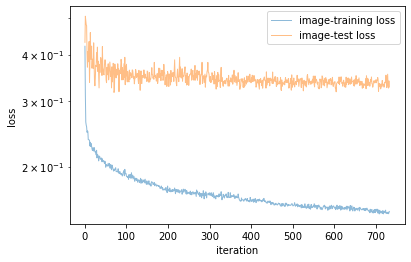

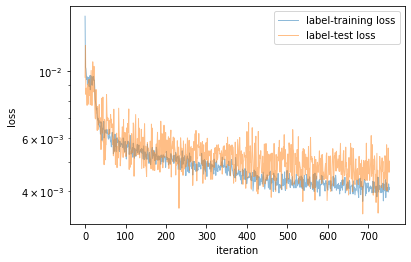

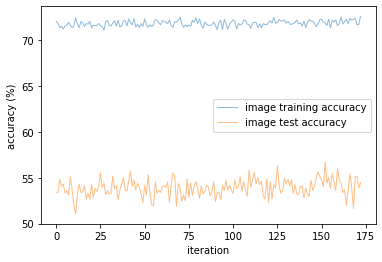

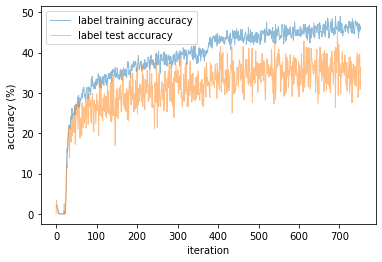

In [36]:
fig = plt.figure()
plt.plot(image_trainer.train_loss_list, alpha=0.5, linewidth=1, label="image-training loss")
plt.plot(image_trainer.test_loss_list, alpha=0.5, linewidth=1, label="image-test loss")
plt.xlabel ('iteration')
plt.ylabel ('loss')
plt.yscale ('log')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'image_recovery_loss.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

fig = plt.figure()
plt.plot(label_trainer.train_loss_list, alpha=0.5, linewidth=1, label="label-training loss")
plt.plot(label_trainer.test_loss_list, alpha=0.5, linewidth=1, label="label-test loss")
plt.ylabel ('loss')
plt.xlabel ('iteration')
plt.yscale ('log')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'label_loss.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

fig = plt.figure()
plt.plot(100.0 * np.array(image_trainer.train_accuracy_list), alpha=0.5, linewidth=1, label="image training accuracy")
plt.plot(100.0 * np.array(image_trainer.test_accuracy_list), alpha=0.5, linewidth=1, label="image test accuracy")
plt.ylabel ('accuracy (%)')
plt.xlabel ('iteration')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'image_accuracy.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)
    
fig = plt.figure()
plt.plot(100.0 * np.array(label_trainer.train_accuracy_list), alpha=0.5, linewidth=1, label="label training accuracy")
plt.plot(100.0 * np.array(label_trainer.test_accuracy_list), alpha=0.5, linewidth=1, label="label test accuracy")
plt.ylabel ('accuracy (%)')
plt.xlabel ('iteration')
plt.legend ()

if save_figures:
    fig.savefig(result_dir + 'label_accuracy.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

In [37]:
# img = image_loader.image_preprocessing_function(tifffile.imread(result_dir + "member_mohsen_cropped.tiff").astype(np.float32),
#                                                 data_generator_img_img.dataset_mean, data_generator_img_img.dataset_std).reshape((1, 256, 256, 1))
# print(img.shape)
# print(np.amin(img), np.amax(img))

# plt.imshow(img[0, :, :, 0])

In [38]:
# output = dd_model(img, training=False)

# gen_image_test = output[0].numpy()

# plt.figure(figsize=(10, 10))
# plt.imshow(img[0, :, :, 0])
# plt.figure(figsize=(10, 10))
# plt.imshow(gen_image_test[0, :, :, 0])

In [81]:
n = 0

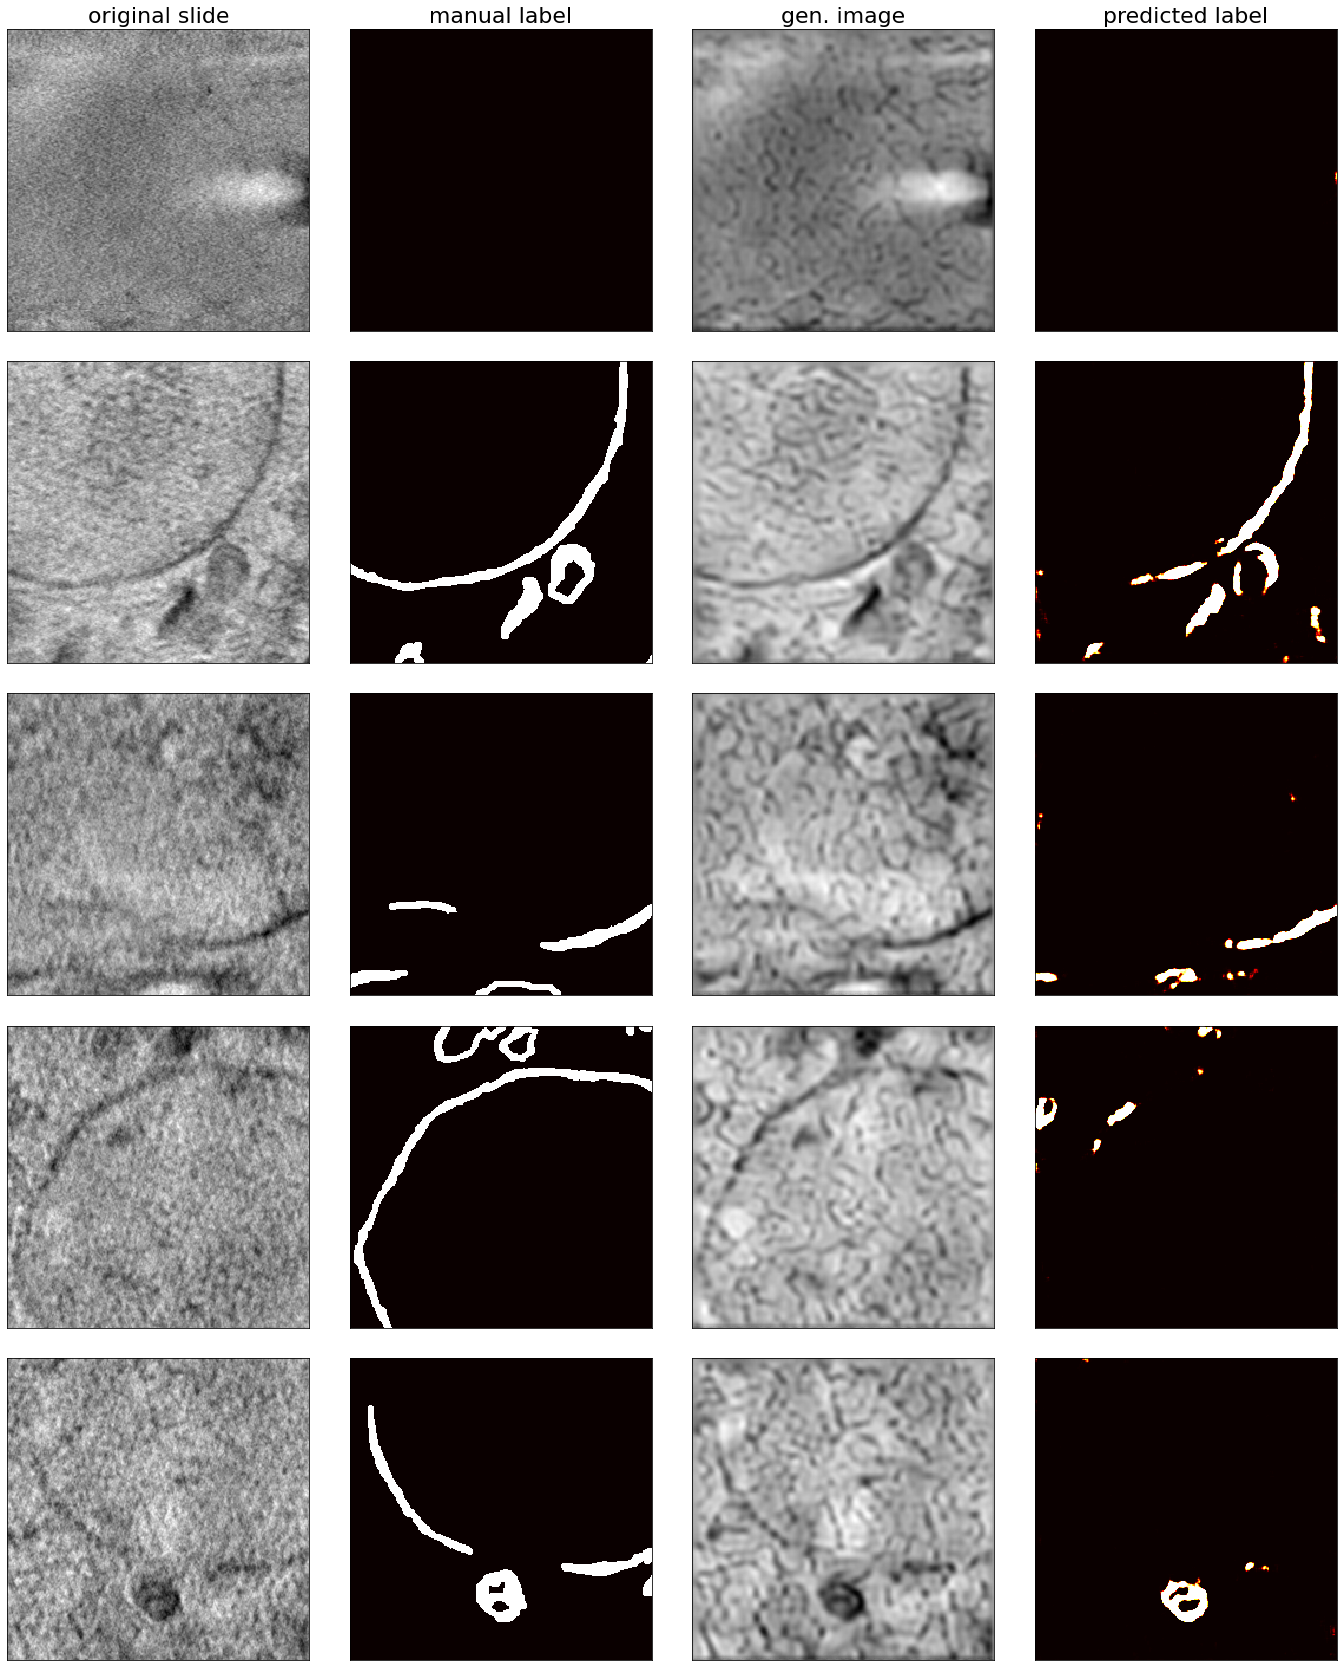

In [108]:
n_results = 5

fig, ax = plt.subplots(n_results, 4, figsize = (24, n_results * 6.0), gridspec_kw={'wspace':0.1, 'hspace':0.1})

n += 1

for i, (img, lbl) in zip(range(n_results), test_dataset_img_lbl):
    
    output = dd_model(img, training=False)

    gen_image_test = output[0].numpy()
    predicted_label_test = output[1].numpy()

    ind = 0
    
    ax[i, 0].imshow (img[ind, :, :, 0], cmap='gray', interpolation='nearest')
    
    ax[i, 1].imshow (lbl[ind, :, :, 0], cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)
    
    ax[i, 2].imshow (gen_image_test[ind, :, :, 0], cmap='gray', interpolation='nearest')
    
    ax[i, 3].imshow (predicted_label_test[ind, :, :, 0], cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)

    if i == 0:
        ax[i, 0].set_title("original slide", fontsize=22)
        ax[i, 1].set_title("manual label", fontsize=22)
        ax[i, 2].set_title("gen. image", fontsize=22)
        ax[i, 3].set_title("predicted label", fontsize=22)
    
    for j in range(4):
        ax[i, j].tick_params(
            axis='both',
            which='both',
            bottom=False,     
            top=False, 
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False)
        
if save_figures:
    fig.savefig(result_dir + 'prediction_' + str(n) + '.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

In [ ]:
# dat = test_dataset_img_lbl.as_numpy_iterator()

# img, lbl = next(dat)

# print(img.shape)

# x, skip_x = dd_model.encoder(img, training=False)

# y = dd_model.mid_branch[0](x, training=False)

# for _branch in dd_model.mid_branch[1:]:
#     y = tf.concat([y, _branch(x, training=False)], axis=-1)

# output = dd_model.decoder_image(y, skip_x, training=False).numpy()

# print(output.shape)

# plt.imshow(output[0, :, :, 0])

In [29]:
#tomo_name = "19_03_SIRT100x"
#tomo_name = "20_07_22_SV40_1"
# tomo_name = "20_09_23_SV40"

#print(tomo_name)
#tomo_name = "20_10_19_filopodia_SIRT50x"
# tomo_name = "20_10_19_filopodia_8bit"


# tomogram = np.load (working_dir + "tomograms/tomo_restored_2.npy")
# tomogram = np.load (working_dir + "tomograms/tomo_restored_june_2020_1.npy")

tomo_name = "20201120-05-SIRT20-16bit"

tomogram = np.load (working_dir + "tomograms/processed/tomo_restored_" + tomo_name + ".npy")
# tomogram = tomo_img1.reshape((1, tomo_img1.shape[0], tomo_img1.shape[1]))

print(np.amin(tomogram), np.amax(tomogram))
print(tomogram.shape)

0.0 1.0
(351, 1324, 1284)


992 992
(231, 1324, 1284)
number of slices: 231
Tomogram dimensions: (1324, 1284)


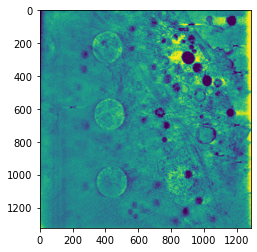

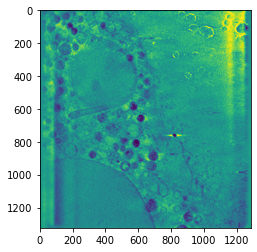

In [30]:
x1 = 236
x2 = 854

y1 = 405
y2 = 1245

x1 = 0
x2 = 1324

#x1 = 200
x2 = 1000

y1 = 0
y2 = 1284

#y1 = 200
y2 = 1000

offset_x = x1
offset_y = y1

l_x = x2 - x1
l_y = y2 - y1

while l_x % 16 > 0: l_x -= 1
while l_y % 16 > 0: l_y -= 1

print(l_x, l_y)
# sel_slices = tomogram[250:600, :, :]

#sel_slices = tomogram[100:-70, offset_x:offset_x + l_x, offset_y:offset_y + l_y]
#sel_slices = tomogram[50:-70, offset_x:offset_x + l_x, offset_y:offset_y + l_y]
sel_slices = tomogram[50:-70, :, :]
print(sel_slices.shape)
# sel_slices = tomogram[10:-10, offset_x:offset_x + l_x, offset_y:offset_y + l_y]

tomo_dim = sel_slices[0, :, :].shape
n_slices = sel_slices.shape[0]

print(f"number of slices: {n_slices}")
print(f"Tomogram dimensions: {tomo_dim}")

plt.figure()
plt.imshow(sel_slices[0, :, :])
plt.figure()
plt.imshow(sel_slices[-1, :, :])

In [31]:
def enhance_tomogram(img):
    
#     img = normalize(img)
#     img = denoise_tv_chambolle(img, weight=0.02, multichannel=False)
    img = image_loader.image_preprocessing_function(img, np.mean(img), np.std(img))

#     _m = np.mean(img)

#     img = np.clip(0.1 * (img - _m) + _m, 0.0, 1.0)
    
#     img = unsharp_mask(img, radius=5.0, amount=10)
    
    return img.astype(np.float32)

(231, 1324, 1284)


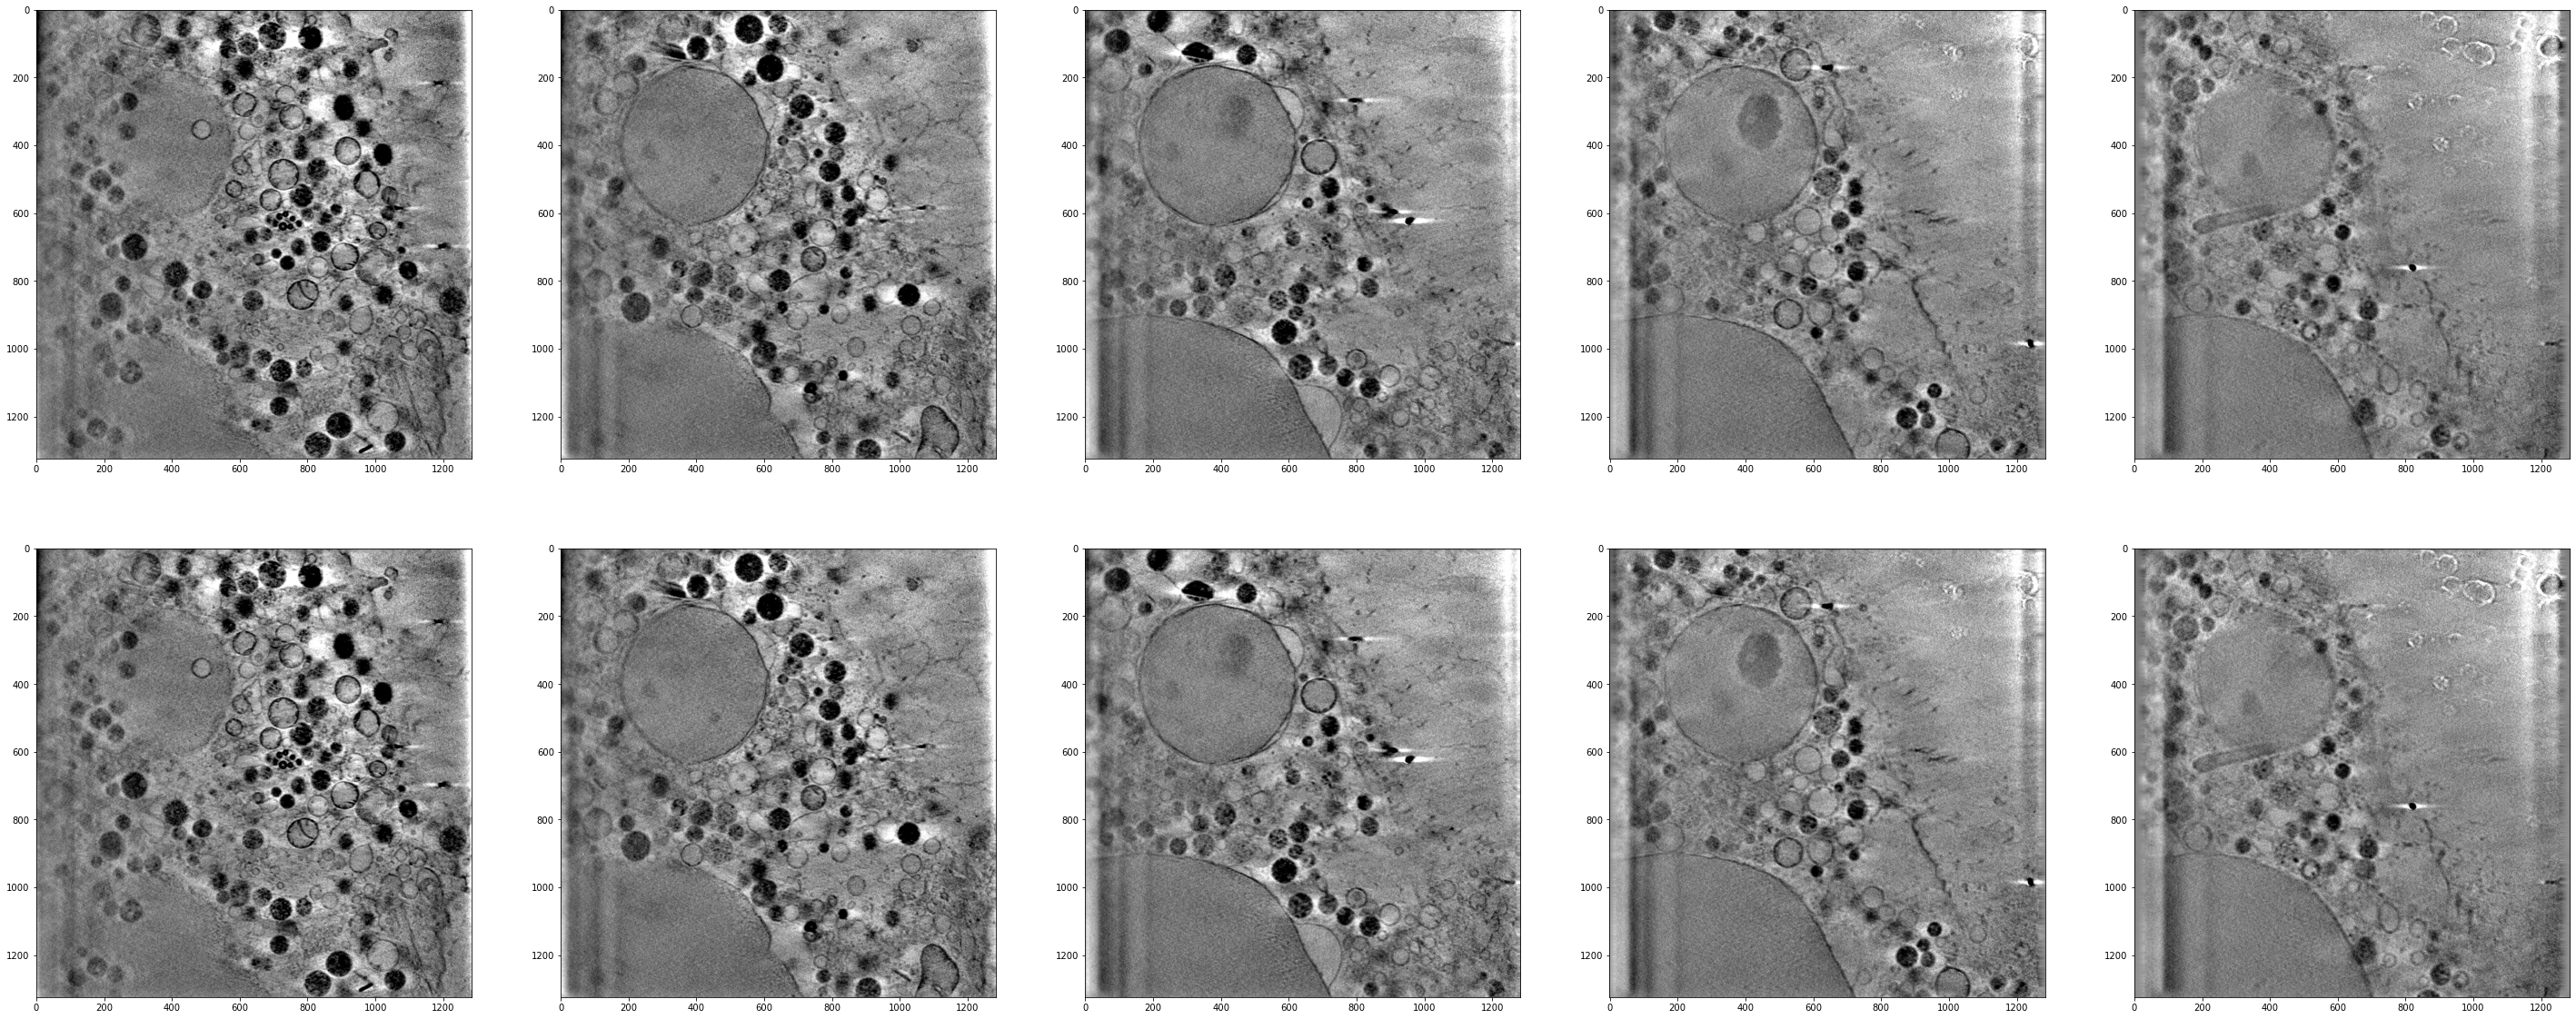

In [32]:
print(sel_slices.shape)
n_pics = 5

fig = plt.figure (figsize = (10 * n_pics, 20))

for i in range(n_pics):
    ax = fig.add_subplot(2, n_pics, i + 1)
    
    _img = sel_slices[n_slices // n_pics * (i + 1) - 1, :, :]
    
    ax.imshow (_img, cmap='gray', vmax=1.0)
    
    ax = fig.add_subplot(2, n_pics, i + 1 + n_pics)
    
    ax.imshow (enhance_tomogram(_img), cmap='gray')    

In [33]:
def predict_slice(img, chunk_size, stride, model):
    
    stride_x = stride
    stride_y = stride
    
    while chunk_size % 16 > 0 : chunk_size -= 1
    while ((img.shape[0] - chunk_size) % stride_x > 0) : stride_x -= 1
    while ((img.shape[1] - chunk_size) % stride_y > 0) : stride_y -= 1

    print(f"chunk size = {chunk_size}")
    print(f"stride = {(stride_x, stride_y)}")
    
    output_img = np.zeros_like(img)
    output_lbl = np.zeros_like(img)
    
    n_output = np.zeros_like(img)
    
    d_ind_x = np.array([stride_x, stride_x], dtype=np.int32)
    d_ind_y = np.array([stride_y, stride_y], dtype=np.int32)
    
    ind_y = np.array([0, chunk_size], dtype=np.int32)
    
    while (ind_y[1] <= img.shape[1]):
        
        ind_x = np.array([0, chunk_size], dtype=np.int32)
        
        while (ind_x[1] <= img.shape[0]):
                
            chunk_img = img[ind_x[0]:ind_x[1], ind_y[0]: ind_y[1]].copy()
                        
            chunk_output = model(chunk_img.reshape((1, chunk_img.shape[0], chunk_img.shape[1], 1)), training=False)
            
            predicted_img = chunk_output[0].numpy()[0, :, :, 0].astype(np.float32)
            predicted_lbl = chunk_output[1].numpy()[0, :, :, 0].astype(np.float32)

            output_img[ind_x[0]:ind_x[1], ind_y[0]: ind_y[1]] += predicted_img
            output_lbl[ind_x[0]:ind_x[1], ind_y[0]: ind_y[1]] += predicted_lbl
            
            n_output[ind_x[0]:ind_x[1], ind_y[0]: ind_y[1]] += np.ones_like(chunk_img)

            ind_x += d_ind_x
                
        ind_y += d_ind_y
            
    output_img /= n_output
    output_lbl /= n_output
    
    return output_img, output_lbl

In [34]:
# img_patch = sel_slices[:, :, :].reshape((-1, tomo_dim[0], tomo_dim[1], 1))

#selem = skmorph.disk(4)

predicted_img = []
predicted_lbl = []

input_img = []

n_slices = sel_slices.shape[0]

ind_list = []

for i in tqdm(range(0, n_slices, 40)):

    ind_list.append(i)

    img_patch = enhance_tomogram(sel_slices[i, :, :])
    
    input_img.append(img_patch.copy())
    
#     predicted_slice = dd_model(img_patch.reshape((-1, tomo_dim[0], tomo_dim[1], 1)), training=False)
    predicted_slice = predict_slice(img_patch, 500, 400, dd_model)
    
    predicted_img.append(predicted_slice[0].astype(np.float32))
    predicted_lbl.append((predicted_slice[1] > 0.0).astype(np.int16))
    
    
predicted_img = np.array (predicted_img)
predicted_lbl = np.array (predicted_lbl)

  0%|          | 0/6 [00:00<?, ?it/s]

chunk size = 496
stride = (276, 394)
chunk size = 496
stride = (276, 394)
chunk size = 496
stride = (276, 394)
chunk size = 496
stride = (276, 394)
chunk size = 496
stride = (276, 394)
chunk size = 496
stride = (276, 394)


  0%|          | 0/6 [00:00<?, ?it/s]

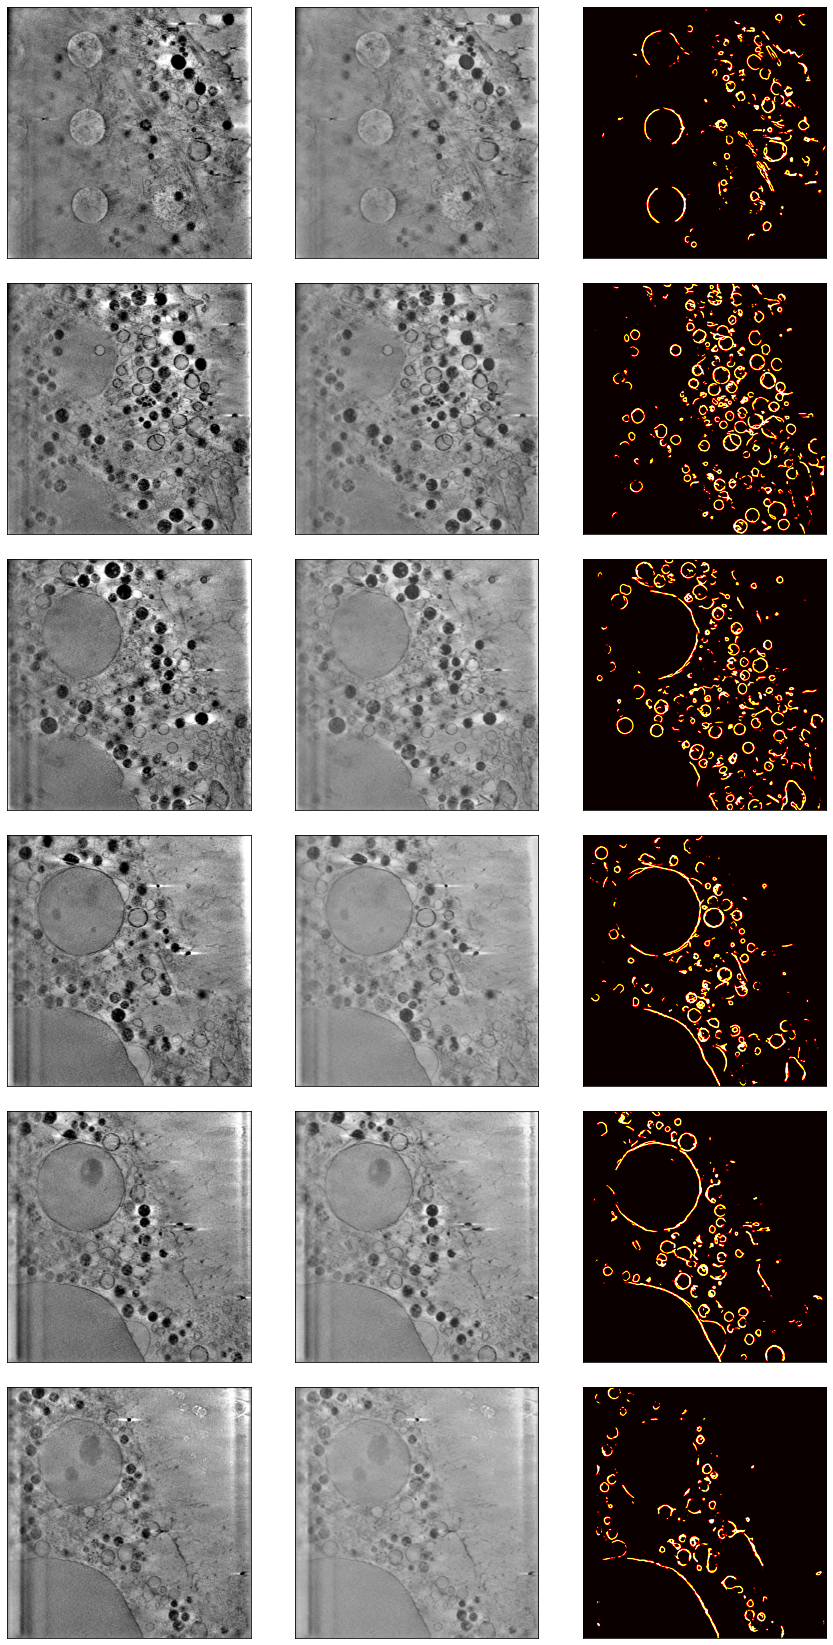

In [35]:
#%%capture out

n_images = len(ind_list)

fig, ax = plt.subplots(n_images, 3, figsize = (15, 5 * n_images), gridspec_kw={'wspace':0.1, 'hspace':0.1})

for i in tqdm(range(len(predicted_img))):

    ax[i, 0].imshow (input_img[i], cmap='gray')
    ax[i, 1].imshow (predicted_img[i], cmap='gray')
    ax[i, 2].imshow (predicted_lbl[i], cmap='hot', vmin=0.0, vmax = 1.0)
    
    for j in range(3):
        ax[i, j].tick_params(
                    axis='both',
                    which='both',
                    bottom=False,     
                    top=False, 
                    left=False,
                    right=False,
                    labelbottom=False,
                    labelleft=False)
        
if save_figures:
    fig.savefig(result_dir + 'segmented_' + tomo_name + '.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

## Applying the network to the whole tomogram

In [ ]:
img_patch = sel_slices[:, :, :].reshape((-1, tomo_dim[0], tomo_dim[1], 1))
enh_tomo = []

print("enhancing the tomogram...")

for _img in tqdm(img_patch):

    enh_tomo.append(enhance_tomogram(_img[:, :, 0]).reshape((tomo_dim[0], tomo_dim[1], 1)))
        
enh_tomo = np.array(enh_tomo)

In [ ]:
print("running it through the network...")

segmented_tomo = []

for i in tqdm(range(n_slices)):

    predicted_slice = model(enh_tomo[n_slices - i - 1].reshape((-1, tomo_dim[0], tomo_dim[1], 1)), training=False)

    pred_lbl = (predicted_slice.numpy()[0, :, :, 0] > 0.5).astype(np.float64)
    
#     pred_lbl = skmorph.closing(pred_lbl, selem)
    
    segmented_tomo.append(pred_lbl.astype(np.uint8))
        
segmented_tomo = np.array(segmented_tomo)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(segmented_tomo[100], cmap="gray", vmin=0.0, vmax=1.0)

In [ ]:
#np.save (working_dir + "annotated_slices/segmented_" + tomo_name + "_4", segmented_tomo)
np.save (working_dir + "annotated_slices/segmented_" + tomo_name + "_" + name_str + "_1", segmented_tomo)

In [ ]:
print(name_str)